# Credit Default

## Оглавление:

* [Постановка задачи](#target_setting)
* [Подключение библиотек и скриптов](#load_libs_scripts)
* [Загрузка исходных данных](#load_data)
    * [Пути к директориям и файлам](#path_data)
    * [Загрузка данных](#load_dataset)
* [Обзор данных](#data_overview)
    * [Обзор целевой переменной](#target_feature_overview)
    * [Обзор количественных признаков](#num_features_overview)
    * [Обзор номинативных признаков](#cat_features_overview)
* [Анализ данных (Exploratory Data Analysis (EDA))](#eda)
    * [Приведение типов](#cast)
    * [Выделение целевой переменной и групп признаков](#feature_splitting)
    * [Анализ количественных признаков](#num_faeture_eda)
    * [Анализ категориальных признаков](#cat_faeture_eda)
* [Предварительная обработка данных](#data_preprocessing)
    * [Сокращение количества значений в категориальных признаках](#reducing_number_values_cat_features)
    * [Заполнение пропусков и обработка выбросов](#data_preprocessing)
    * [Конвертация категориальных признаков в цифровой вид](#cat_feature_convert)
    * [Проверка распределения вещественных признаков на трейне и тесте](#num_feature_distribution_checking)
    * [Проверка распределение категориальных признаков на трейне и тесте](#cat_feature_distribution_checking)
* [Построение моделей (XGBoost)](#xgboost_modeling) 
    * [Отбор признаков](#feature_selection)
    * [Масштабирование данных](#scaler)
    * [Обучение модели](#model_training)
    * [Выбор лучшей модели и подбор гиперпараметров](#tuning_best_model)
    * [Подбор оптимального размера выборки, кривая обучения](#learning_curve)
    * [Выбор порога вероятности для определения класса](#threshold_calibration)
    * [Важность признаков](#feature_importances)
    * [Построение финальной модели](#final_model)
    * [Сохранение финальной модели](#final_model_saving)
* [Прогнозирование на тестовом датасете](#forecasting_test_dataset)

## Постановка задачи<a class="anchor" id="target setting"></a>

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

## Подключение библиотек и скриптов<a class="anchor" id="load_libs_scripts"></a>

**Используемые библиотеки**

In [1]:
#!pip install xgboost
# !pip install lightgbm
# !pip install catboost
#!pip install imbalanced-learn

In [2]:
# Libraries for working with paths and saving
from pathlib import Path
import os
import pickle

# Scientific libraries
import numpy as np
import pandas as pd
import random

# Statistical libraries
from scipy.stats import mannwhitneyu

# Visual libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('seaborn')

# Scikit-learn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Model libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


import xgboost as xgb

In [3]:
print(f'Версия xgboost: {xgb.__version__}')
!python --version

Версия xgboost: 1.5.1
Python 3.9.7


In [4]:
import warnings
warnings.filterwarnings('ignore')

**Используемые функции**

In [5]:
# функция для вывода отчетов классификации

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred)) #подсчет классификации для train
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred)) #подсчет классификации для test
    print('CONFUSION MATRIX\n') #матрица ошибок
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
# функция подсчета предсказаний и вывода отчетов классификации на обучении и тесте

def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train) # подсчет предсказаний  на train
    y_test_pred = model.predict(X_test) # подсчет предсказаний  на test
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred) # вывод отчета классификации

In [7]:
# функция балансировки классов по целевой переменной

def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [8]:
# функция для поиска оптимальной отсечки

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [9]:
# функция показывает зависимости метрики от разного количества объектов

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [10]:
# функция вывода важности признаков для модели

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## Загрузка исходных данных<a class="anchor" id="load_data"></a>

### Пути к директориям и файлам<a class="anchor" id="path_data"></a>

In [11]:
DATA_ROOT = Path('../')
MODELS_PATH = Path('../2_models/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / '1_input_data/train.csv'
TEST_DATASET_PATH = DATA_ROOT / '1_input_data/test.csv'

# output
TRAIN_FULL_PATH = DATA_ROOT / 'training_project_train_full.csv'
TRAIN_PART_PATH = DATA_ROOT / 'training_project_train_part_b.csv'
TEST_PART_PATH = DATA_ROOT / 'training_project_test_part.csv'
SUBMISSION_PATH = DATA_ROOT / 'sample_submission.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

### Загрузка данных<a class="anchor" id="load_dataset"></a>

**Описание базового датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [12]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [13]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [14]:
print('Тренировочный датасет df_train:', df_train.shape)
print('Тестовый датасет df_test:', df_test.shape)

Тренировочный датасет df_train: (7500, 17)
Тестовый датасет df_test: (2500, 16)


**Проверка датасетов на соответствие**

In [15]:
df_train.shape[1] - 1 == df_test.shape[1]

True

Тренировочный и тестовый датасеты имеют одинаковую структуру

## Обзор данных<a class="anchor" id="data_overview"></a>

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Имеются пропуски в параметрах Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score

In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Аналогично тренировочному датасету, видем пропуски в параметрах Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score

### Обзор целевой переменной<a class="anchor" id="target_feature_overview"></a>

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [18]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

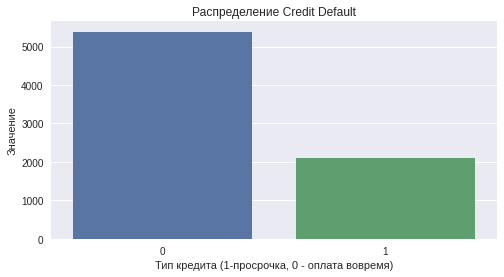

In [19]:
counts = df_train['Credit Default']. value_counts()

plt.figure(figsize=(8,4))
plt.title('Распределение Credit Default')
sns.barplot(counts.index, counts.values)
plt.xlabel('Тип кредита (1-просрочка, 0 - оплата вовремя)')
plt.ylabel('Значение')
plt.show()

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту).
Присутствует разбалансировка. Количество просроченных кредитов - 28,2%. Осталные 71,8% просрочек не имеют.
Пропуски отсутствуют.

### Обзор количественных признаков<a class="anchor" id="num_features_overview"></a>

In [20]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [21]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.0,1.366922e+06,9.171252e+05,106533.0,852311.50,1178475.0,1629734.5,14975610.0
Tax Liens,2500.0,3.520000e-02,3.862909e-01,0.0,0.00,0.0,0.0,15.0
Number of Open Accounts,2500.0,1.118440e+01,4.852774e+00,1.0,8.00,10.0,14.0,48.0
Years of Credit History,2500.0,1.832592e+01,7.254659e+00,3.9,13.40,17.0,22.1,53.4
Maximum Open Credit,2500.0,7.105704e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,54484386.0
Number of Credit Problems,2500.0,1.620000e-01,5.598941e-01,0.0,0.00,0.0,0.0,15.0
Months since last delinquent,1142.0,3.418126e+01,2.202428e+01,0.0,16.00,30.0,50.0,82.0
Bankruptcies,2497.0,1.069283e-01,3.571893e-01,0.0,0.00,0.0,0.0,5.0
Current Loan Amount,2500.0,1.215572e+07,3.226097e+07,15422.0,187126.50,322366.0,522582.5,99999999.0
Current Credit Balance,2500.0,2.963966e+05,3.783020e+05,0.0,110114.50,207385.0,366348.5,6030087.0


Вызывает вопросы распределение параметров Tax Liens, Number of Credit Problems, Bankruptcies. Не похоже оно на распределение количественных переменных. Подробнее посмотрим на графиках. 
Возможно наличие выбросов в параметрах Current Loan Amount, Credit Score, Maximum Open Credit

### Обзор номинативных признаков<a class="anchor" id="cat_features_overview"></a>

In [22]:
df_train.describe(include='object').T

,count,unique,top,freq
Home Ownership,7500,4,Home Mortgage,3637
Years in current job,7129,11,10+ years,2332
Purpose,7500,15,debt consolidation,5944
Term,7500,2,Short Term,5556


In [23]:
df_test.describe(include='object').T

,count,unique,top,freq
Home Ownership,2500,4,Home Mortgage,1225
Years in current job,2414,11,10+ years,810
Purpose,2500,14,debt consolidation,1973
Term,2500,2,Short Term,1861


## Анализ данных (Exploratory Data Analysis (EDA))<a class="anchor" id="eda"></a>

### Приведение типов<a class="anchor" id="cast"></a>

Произведя обзор исходных датасетов, можно сделать вывод, что необходимо выполнить преобразования типов данных.

In [24]:
for colname in ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']:
    df_train[colname] = df_train[colname].astype(str)
for colname in ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']:
    df_test[colname] = df_test[colname].astype(str)

**После приведения типов имеем следующую картину**

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   object 
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   object 
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7500 non-null   object 
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   object 
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   object 
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2500 non-null   object 
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [27]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06
Monthly Debt,7500.0,1.831445e+04,1.192676e+04,0.0,10067.5,16076.5,23818.00,1.366790e+05
Credit Score,5943.0,1.151087e+03,1.604451e+03,585.0,711.0,731.0,743.00,7.510000e+03
Credit Default,7500.0,2.817333e-01,4.498740e-01,0.0,0.0,0.0,1.00,1.000000e+00


In [28]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.0,1.366922e+06,9.171252e+05,106533.0,852311.50,1178475.0,1629734.5,14975610.0
Number of Open Accounts,2500.0,1.118440e+01,4.852774e+00,1.0,8.00,10.0,14.0,48.0
Years of Credit History,2500.0,1.832592e+01,7.254659e+00,3.9,13.40,17.0,22.1,53.4
Maximum Open Credit,2500.0,7.105704e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,54484386.0
Months since last delinquent,1142.0,3.418126e+01,2.202428e+01,0.0,16.00,30.0,50.0,82.0
Current Loan Amount,2500.0,1.215572e+07,3.226097e+07,15422.0,187126.50,322366.0,522582.5,99999999.0
Current Credit Balance,2500.0,2.963966e+05,3.783020e+05,0.0,110114.50,207385.0,366348.5,6030087.0
Monthly Debt,2500.0,1.827134e+04,1.154388e+04,93.0,10024.75,16642.5,24146.0,93555.0
Credit Score,1987.0,1.234517e+03,1.740219e+03,585.0,710.00,731.0,743.0,7480.0


In [29]:
df_train.describe(include='object').T

,count,unique,top,freq
Home Ownership,7500,4,Home Mortgage,3637
Years in current job,7129,11,10+ years,2332
Tax Liens,7500,8,0.0,7366
Number of Credit Problems,7500,8,0.0,6469
Bankruptcies,7500,6,0.0,6660
Purpose,7500,15,debt consolidation,5944
Term,7500,2,Short Term,5556


In [30]:
df_test.describe(include='object').T

,count,unique,top,freq
Home Ownership,2500,4,Home Mortgage,1225
Years in current job,2414,11,10+ years,810
Tax Liens,2500,8,0.0,2445
Number of Credit Problems,2500,8,0.0,2177
Bankruptcies,2500,7,0.0,2252
Purpose,2500,14,debt consolidation,1973
Term,2500,2,Short Term,1861


### Выделение целевой переменной и групп признаков<a class="anchor" id="feature_splitting"></a>

In [31]:
TARGET_NAME = 'Credit Default'

TRAIN_FEATURE_NAMES = ['Home Ownership',
                       'Annual Income',
                       'Years in current job',
                       'Tax Liens',
                       'Number of Open Accounts',
                       'Years of Credit History',
                       'Maximum Open Credit',
                       'Number of Credit Problems',
                       'Months since last delinquent',
                       'Bankruptcies',
                       'Purpose',
                       'Term',
                       'Current Loan Amount',
                       'Current Credit Balance',
                       'Monthly Debt',
                       'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership',
                     'Years in current job',
                     'Tax Liens',
                     'Number of Credit Problems',
                     'Bankruptcies',
                     'Purpose',
                     'Term']

NUM_FEATURE_NAMES = ['Annual Income',
                     'Number of Open Accounts',
                     'Years of Credit History',
                     'Maximum Open Credit',
                     'Months since last delinquent',
                     'Current Loan Amount',
                     'Current Credit Balance',
                     'Monthly Debt',
                     'Credit Score']

### Анализ количественных признаков<a class="anchor" id="num_faeture_eda"></a>

**Корреляция с базовыми признаками**

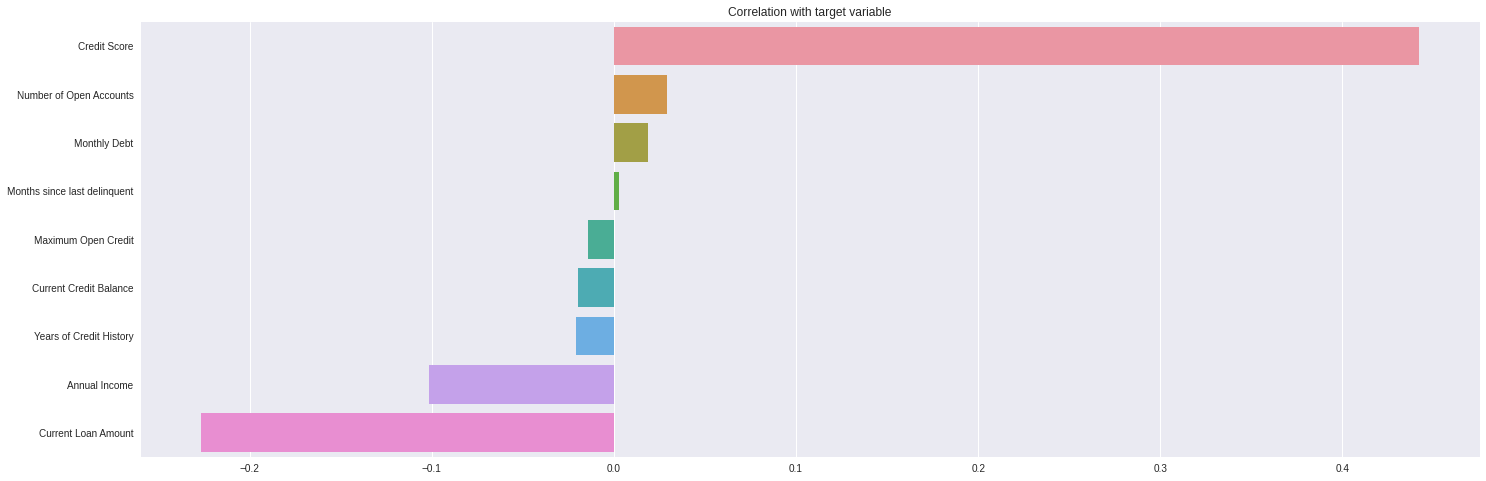

In [32]:
corr_with_target = df_train[TRAIN_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(24, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

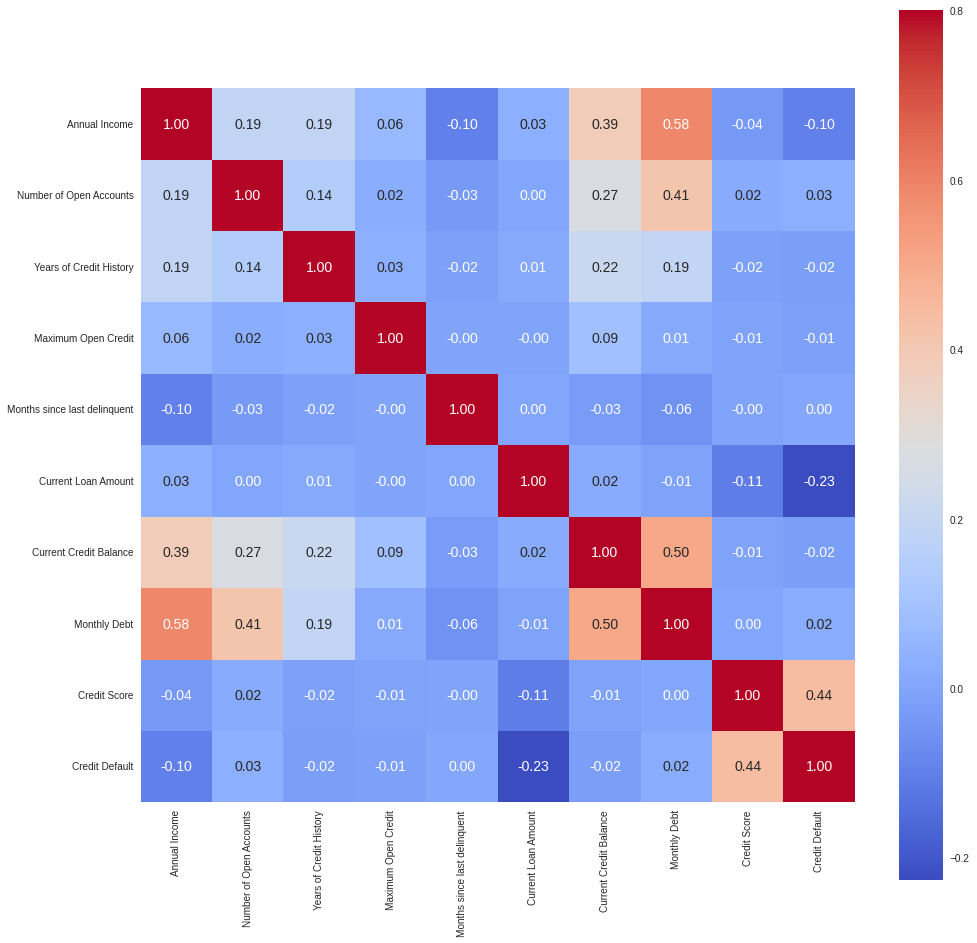

In [33]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corrmat, vmax=.8, annot=True, fmt='.2f', cmap='coolwarm', square=True);

**Выводы:**

* **Annual Income, Number of Open Accounts, Years of Credit History, Current Credit Balance, Monthly Debt** - положительная корреляция между всеми признаками
* **Years of Credit History** имеет небольшую корреляцию с **Annual Income и Number of Open Accounts**.
* **Current Credit Balance** и **Monthly Debt** имеют большую положительную корреляцию. 

#### Annual Income (Годовой доход)

In [34]:
df_train['Annual Income'].isnull().value_counts()

False    5943
True     1557
Name: Annual Income, dtype: int64

In [35]:
df_train['Annual Income'].value_counts().sort_index()

164597.0      1
175845.0      1
177251.0      1
191577.0      1
192223.0      1
             ..
8710740.0     1
8758449.0     1
8923844.0     1
9338880.0     1
10149344.0    1
Name: Annual Income, Length: 5478, dtype: int64

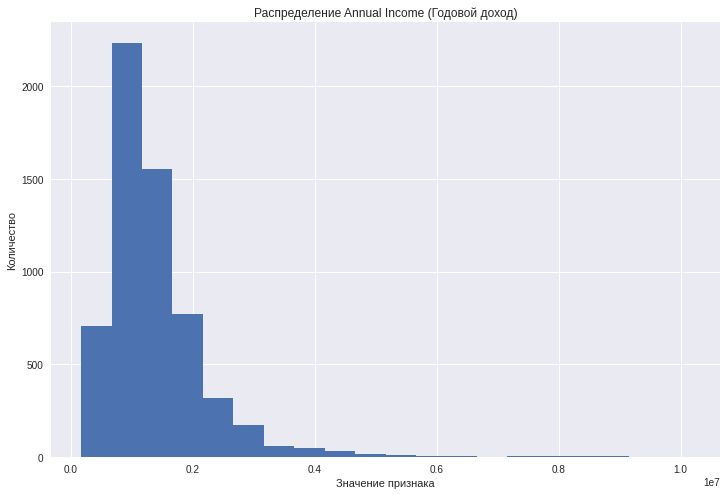

In [36]:
plt.figure(figsize = (12, 8))

df_train['Annual Income'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Annual Income (Годовой доход)')
plt.show()

Выводы:
* 1557 пропусков, их необходимо отработать
* Достаточно длинных хвост в право
* Выбросов не наблюдается 

#### Number of Open Accounts (Количество открытых счетов)

In [37]:
df_train['Number of Open Accounts'].isnull().value_counts()

False    7500
Name: Number of Open Accounts, dtype: int64

In [38]:
df_train['Number of Open Accounts'].value_counts().sort_index()

2.0      28
3.0      95
4.0     212
5.0     325
6.0     504
7.0     613
8.0     638
9.0     728
10.0    677
11.0    692
12.0    562
13.0    465
14.0    420
15.0    313
16.0    265
17.0    232
18.0    143
19.0    139
20.0     93
21.0     78
22.0     49
23.0     59
24.0     50
25.0     32
26.0     12
27.0     14
28.0     14
29.0     10
30.0     11
31.0      6
32.0      6
33.0      6
34.0      2
35.0      1
37.0      2
38.0      1
41.0      1
42.0      1
43.0      1
Name: Number of Open Accounts, dtype: int64

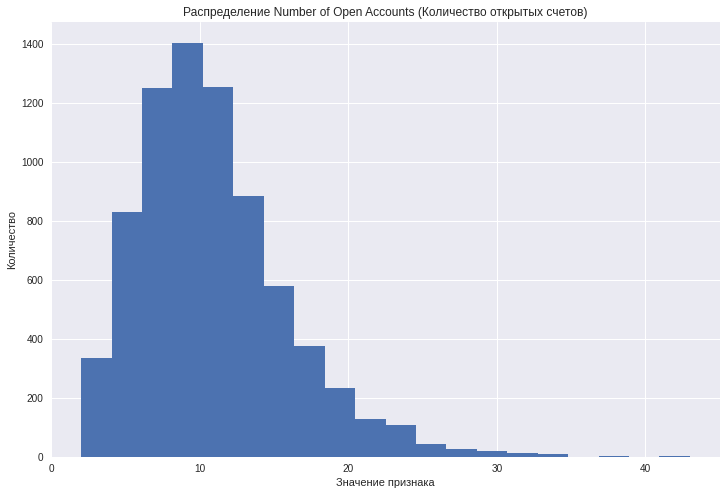

In [39]:
plt.figure(figsize = (12, 8))

df_train['Number of Open Accounts'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Number of Open Accounts (Количество открытых счетов)')
plt.show()

Выводы:
* Пропуски отсутствуют
* Достаточно длинных хвост в право. 
* Возможно есть смысл обрезать значения больше 30 и посчитать их выбросами 

#### Years of Credit History (Количество лет кредитной истории)

In [40]:
df_train['Years of Credit History'].isnull().value_counts()

False    7500
Name: Years of Credit History, dtype: int64

In [41]:
df_train['Years of Credit History'].value_counts().sort_index()

4.0     1
4.3     1
4.5     2
4.7     2
4.8     4
       ..
51.3    1
51.5    1
51.9    1
52.2    1
57.7    1
Name: Years of Credit History, Length: 408, dtype: int64

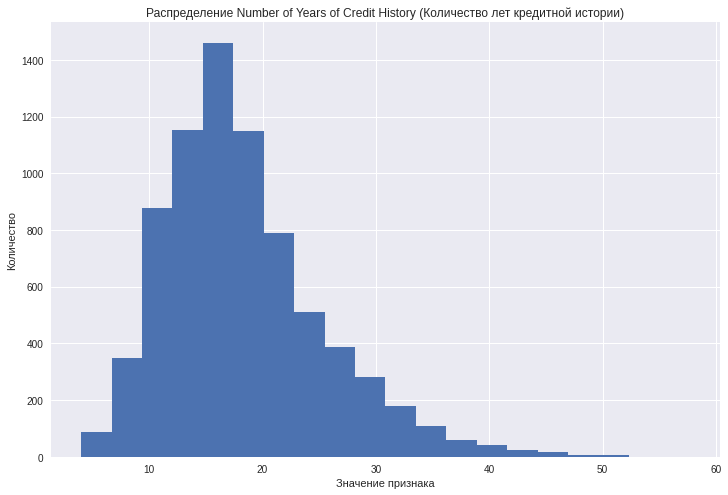

In [42]:
plt.figure(figsize = (12, 8))

df_train['Years of Credit History'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Number of Years of Credit History (Количество лет кредитной истории)')
plt.show()

Выводы:

* Пропуски отсутствуют
* Выбросов не наблюдается 

#### Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)

In [43]:
df_train['Maximum Open Credit'].isnull().value_counts()

False    7500
Name: Maximum Open Credit, dtype: int64

In [44]:
df_train['Maximum Open Credit'].value_counts().sort_index()

0.000000e+00    65
4.334000e+03     1
6.556000e+03     1
6.622000e+03     1
1.089000e+04     1
                ..
4.092389e+07     1
5.756256e+07     1
2.655129e+08     1
3.800523e+08     1
1.304726e+09     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

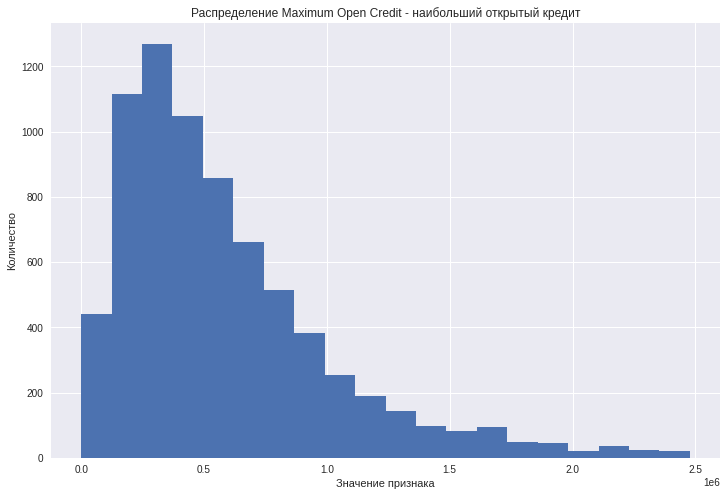

In [45]:
plt.figure(figsize = (12, 8))

mask = df_train['Maximum Open Credit'] < 2500000
df_train.loc[mask, 'Maximum Open Credit'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Maximum Open Credit - наибольший открытый кредит')
plt.show()

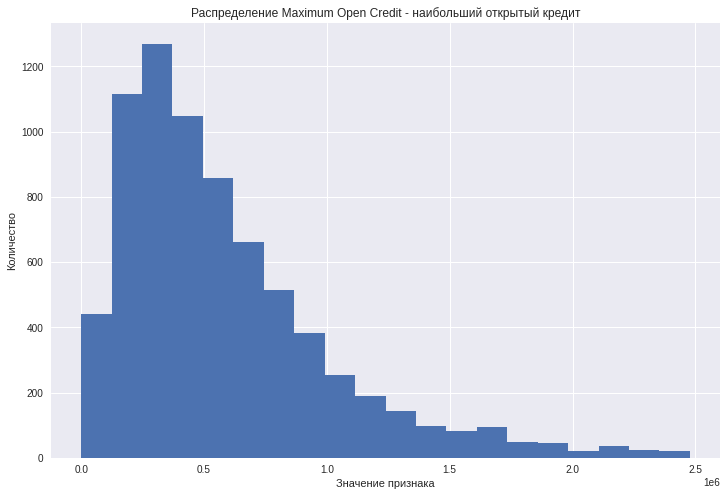

In [46]:
plt.figure(figsize = (12, 8))

mask = df_train['Maximum Open Credit'] < 2500000
df_train.loc[mask, 'Maximum Open Credit'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Maximum Open Credit - наибольший открытый кредит')
plt.show()

In [47]:
mask = df_train['Maximum Open Credit'] > 2500000
len(df_train.loc[mask])

144

Выводы:

* Пропуски отсутствуют
* Есть длинный хвост вправо. 
* Возможно есть смысл обрезать значения больше нескольких миллионов и посчитать их выбросами 

#### Months  since last delinquent -  количество месяцев с последней просрочки  платежа

In [48]:
df_train['Months since last delinquent'].isnull().value_counts()

True     4081
False    3419
Name: Months since last delinquent, dtype: int64

In [49]:
df_train['Months since last delinquent'].value_counts().sort_index()

0.0      18
1.0      26
2.0      25
3.0      30
4.0      31
         ..
84.0      1
86.0      1
91.0      1
92.0      1
118.0     1
Name: Months since last delinquent, Length: 89, dtype: int64

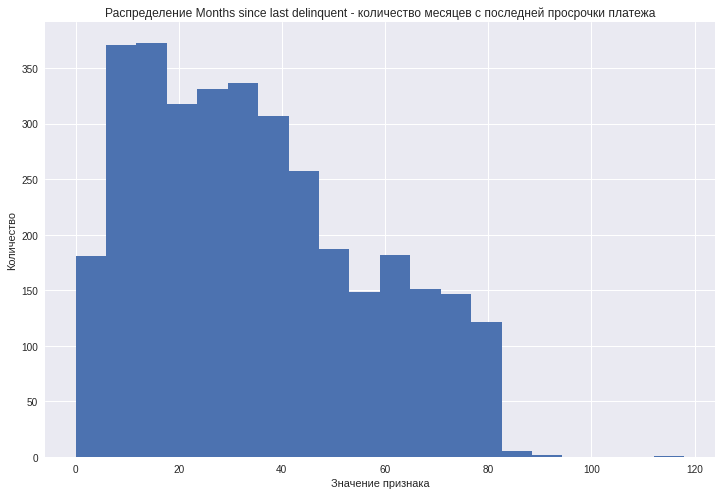

In [50]:
plt.figure(figsize = (12, 8))

df_train['Months since last delinquent'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Months since last delinquent - количество месяцев с последней просрочки платежа')
plt.show()

Выводы:

* 4081 пропуск. Можно предположить, что пропуски - это отсутствие просрочки у клиентов и заменить их нулями
* Возможно есть смысл обрезать значения больше 84, т.к. они встречаются по одному разу, а, также, присутствует отдельно стоящее значение 118, которое очень похоже на выброс 

#### Current  Loan Amount -  текущая сумма кредита (сумма, которую  еще предстоит выплатить клиенту)

In [51]:
df_train['Current Loan Amount'].isnull().value_counts()

False    7500
Name: Current Loan Amount, dtype: int64

In [52]:
df_train['Current Loan Amount'].value_counts().sort_index()

11242.0         1
21472.0         2
21516.0         1
21560.0         1
21582.0         1
             ... 
788634.0        2
788788.0        1
788942.0        1
789030.0        1
99999999.0    870
Name: Current Loan Amount, Length: 5386, dtype: int64

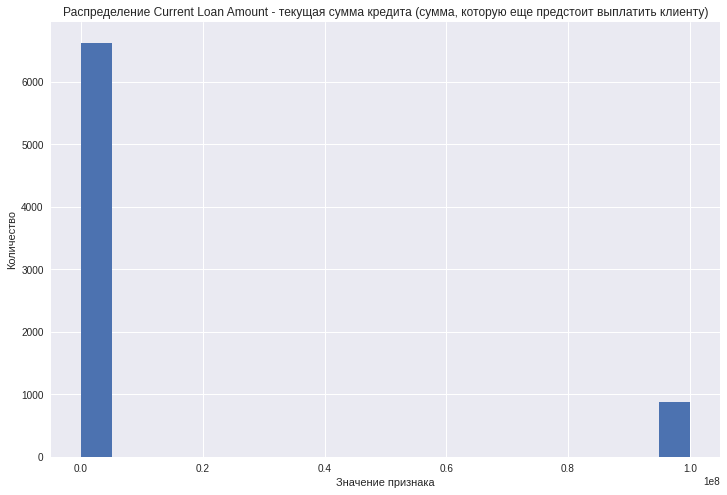

In [53]:
plt.figure(figsize = (12, 8))

mask = df_train['Current Loan Amount'] < 100000000
df_train.loc[mask, 'Current Loan Amount'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)')
plt.show()

In [54]:
mask = df_train['Current Loan Amount'] == 100000000
len(df_train.loc[mask])

0

In [55]:
mask = df_train['Current Loan Amount'] < 100000000
df_train.loc[mask, 'Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

Выводы:

* Пропусков нет
* Возможно есть выбросы со значением 100000000 в количестве 870 шт. Выбросы можно заменить медианой или модой.

#### Current  Credit Balance -  текущий кредитный баланс (сумма, которую  может тратить клиент с кредитного  счета)

In [56]:
df_train['Current Credit Balance'].isnull().value_counts()

False    7500
Name: Current Credit Balance, dtype: int64

In [57]:
df_train['Current Credit Balance'].value_counts().sort_index()

0.0          53
19.0          3
57.0          2
76.0          2
95.0          1
             ..
4209659.0     1
4249673.0     1
4367245.0     1
4720132.0     1
6506797.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

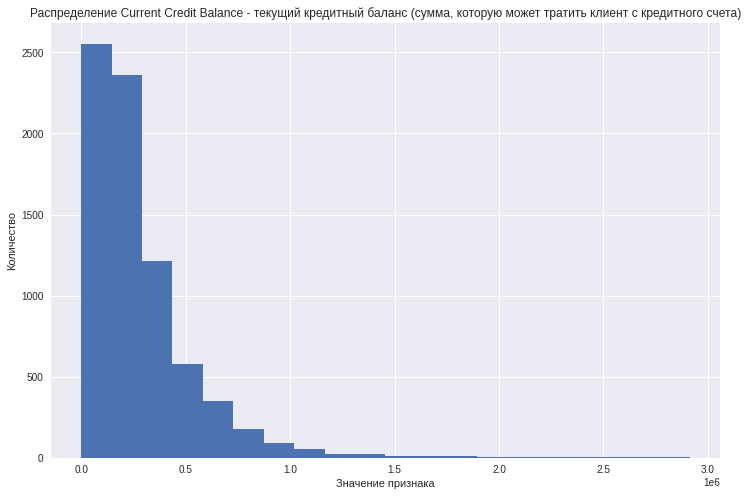

In [58]:
plt.figure(figsize = (12, 8))

mask = df_train['Current Credit Balance'] < 3000000
df_train.loc[mask, 'Current Credit Balance'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)')
plt.show()

In [59]:
mask = df_train['Current Credit Balance'] > 3000000
len(df_train.loc[mask])

10

Выводы:

* Пропусков нет
* Есть длинный хвост вправо.
* Выбросов не обнаружено

#### Monthly  Debt -  ежемесячный долг

In [60]:
df_train['Monthly Debt'].isnull().value_counts()

False    7500
Name: Monthly Debt, dtype: int64

In [61]:
df_train['Monthly Debt'].value_counts().sort_index()

0.0         6
17.0        1
21.0        1
42.0        1
57.0        1
           ..
96177.0     1
100091.0    1
104036.0    1
110311.0    1
136679.0    1
Name: Monthly Debt, Length: 6716, dtype: int64

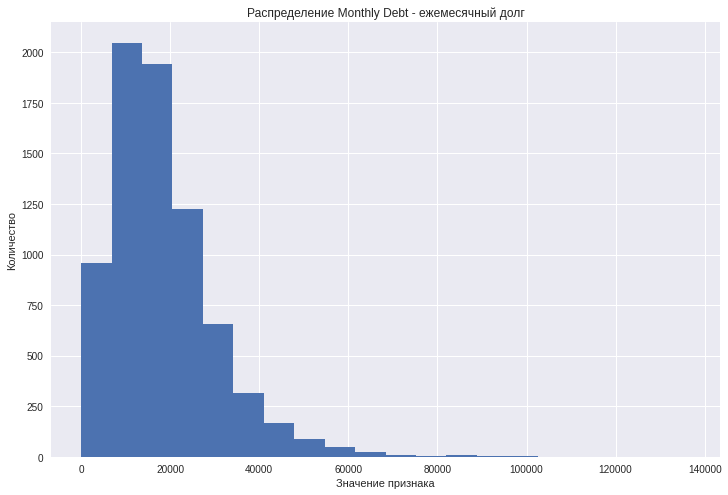

In [62]:
plt.figure(figsize = (12, 8))

df_train['Monthly Debt'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Monthly Debt - ежемесячный долг')
plt.show()

Выводы:

* Пропусков нет
* Есть длинный хвост вправо.
* Выбросов не обнаружено

#### Credit  Score -  баллы кредитного рейтинга

In [63]:
df_train['Credit Score'].isnull().value_counts()

False    5943
True     1557
Name: Credit Score, dtype: int64

In [64]:
df_train['Credit Score'].value_counts().sort_index().tail(200)

662.0      6
663.0     14
664.0      8
665.0     12
666.0     10
          ..
7470.0     4
7480.0     6
7490.0     2
7500.0     2
7510.0     2
Name: Credit Score, Length: 200, dtype: int64

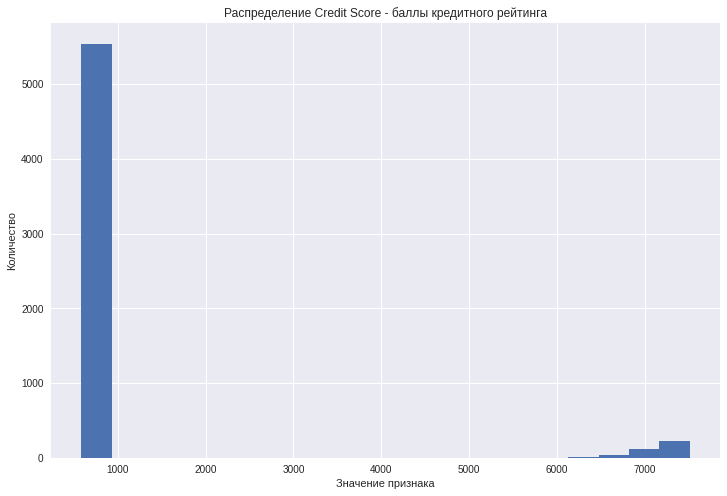

In [65]:
plt.figure(figsize = (12, 8))

#mask = df_train['Credit Score'] < 1000
#df_train.loc[mask, 'Credit Score'].hist(bins=20)
df_train['Credit Score'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Credit Score - баллы кредитного рейтинга')
plt.show()

In [66]:
mask = df_train['Credit Score'] > 1000
len(df_train.loc[mask])

400

Выводы:

* 1557 пропусков. Точно столько же, как и у признака Annual Income. Их необходимо отработать, заменив медианой или модой 
* Есть 400 аномально большими значениями (> 6000),которые можно отнести в выбросам. Их необходимо отработать, например, разделив на 10.  

### Анализ категориальных признаков<a class="anchor" id="cat_faeture_eda"></a>

In [67]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, d

<u>**Выводы (df_train):**</u>  

**Home  Ownership (Домовладение)**  
Пропусков нет  
Не понятно в чем разница между Home Mortgage (ипотека на жильё) и Have Mortgage (есть ипотека). Возможно, есть смысл объединить.   
Выбросов не замечено.  

**Years  in current job (Количество лет на текущем месте работы)**  
371 пропуск. Можно их рассматривать как безработных и заменить на 0 или заменить на моду.  
Большинство у категории 10+ лет работы - 31,1%  
Выбросов не замечено.  

**Tax Liens (Налоговые обременения)**  
Нет пропусков.   
Возможно, это закодированное значение налоговой нагрузки, т.к. представить, что у 98,2% отсутствуют налоговые обременения трудно для любой страны.  
Выбросов не замечено.  

**Number  of Credit Problems (Количество проблем с кредитом)**  
Пропусков нет.   
Подавляющий перевес категории 0 (86,3%), что говорит об отсутствии проблем с кредитами.  
Выбросов не замечено.  

**Bankruptcies (Банкротства)**  
14 пропусков. Необходимо отработать заменив на медиану или моду.  
Перевес в категории 0 (88,8%), что говорит об отсутствии банкротства.  
Выбросов не замечено.  

**Purpose (Цель кредита)**  
Пропуски отстутствуют.  
Перевес по категории debt consolidation (консолидация задолжности) - 79,3%.  
Выбросов не замечено.  

**Term (Срок кредита)**  
Пропусков нет  
Перевес категории коротких кредитов (Short Term) 74,1% по сравнению с длинными (Long Term) 25,9%.  
Выбросов не замечено.  

In [68]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0     2445
1.0       45
2.0        5
5.0        1
4.0        1
6.0        1
3.0        1
15.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0     2177
1.0      280
2.0       29
3.0        7
5.0        4
7.0        1
4.0        1
15.0       1
Name: Number of Credit Proble

<u>**Выводы (df_test):**</u>

**Home  Ownership (Домовладение)**  
Пропусков нет  
Не понятно в чем разница между Home Mortgage (ипотека на жильё) и Have Mortgage (есть ипотека). Возможно, есть смысл объединить.   
Выбросов не замечено.  

**Years  in current job (Количество лет на текущем месте работы)**  
86 пропусков. Можно их рассматривать как безработных и заменить на 0.  
Большинство у категории 10+ лет работы - 32,4%  
Выбросов не замечено.  

**Tax Liens (Налоговые обременения)**  
Нет пропусков.  
Возможно, это закодированное значение налоговой нагрузки, т.к. представить, что у 97,8% отсутствуют налоговые обременения трудно для любой страны.  
Аномальное значение 15, которое не встречалось в df_train. Возможно, частный случай или выброс. Кандидат на исключение.  

**Number  of Credit Problems (Количество проблем с кредитом)**  
Пропусков нет.  
Подавляющий перевес категории 0 (87,1%), что говорит об отсутствии проблем с кредитами.  
Аномальное значение 15, которое не встречалось в df_train. Возможно, частный случай или выброс. Кандидат на исключение.  

**Примечание:**  
Аномальные значения в Tax Liens и Number  of Credit Problems находятся в одной строчке.  

**Bankruptcies (Банкротства)**  
3 пропуска. Необходимо отработать заменив на медиану или моду.  
Перевес в категории 0 (90%), что говорит об отсутствии банкротства.  
Выбросов не замечено.  

**Purpose (Цель кредита)**  
Пропуски отстутствуют.  
Перевес по категории debt consolidation (консолидация задолжности) - 78,9%.  
Выбросов не замечено.  

**Term (Срок кредита)**    
Пропусков нет  
Перевес категории коротких кредитов (Short Term) 74,4% по сравнению с длинными (Long Term) 25,6%.  
Выбросов не замечено.  

In [69]:
df_test.loc[df_test['Tax Liens'] == '15.0']

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2282,Own Home,1410294.0,10+ years,15.0,5.0,20.1,478984.0,15.0,42.0,0.0,debt consolidation,Short Term,447392.0,301549.0,15513.0,746.0


## Предварительная обработка данных<a class="anchor" id="data_preprocessing"></a> 

### Сокращение количества значений в категориальных признаках<a class="anchor" id="reducing_number_values_cat_features"></a> 

Попробуем сократить количество уникальных категорий. Воспользуемся методом доверительных интервалов от целевого значения

Home Ownership: 
 ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage'] 



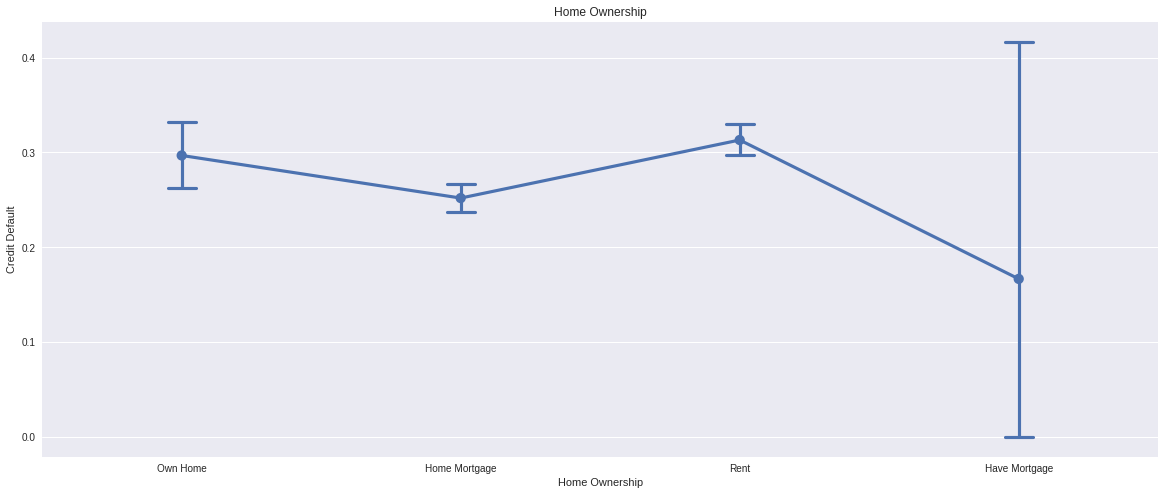

Years in current job: 
 [nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years'] 



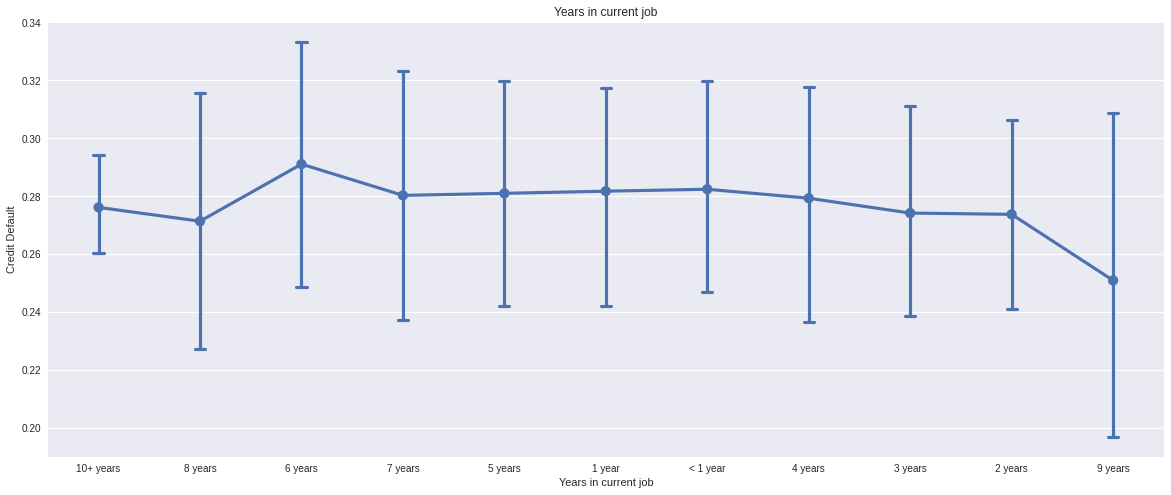

Tax Liens: 
 ['0.0' '3.0' '1.0' '2.0' '4.0' '6.0' '5.0' '7.0'] 



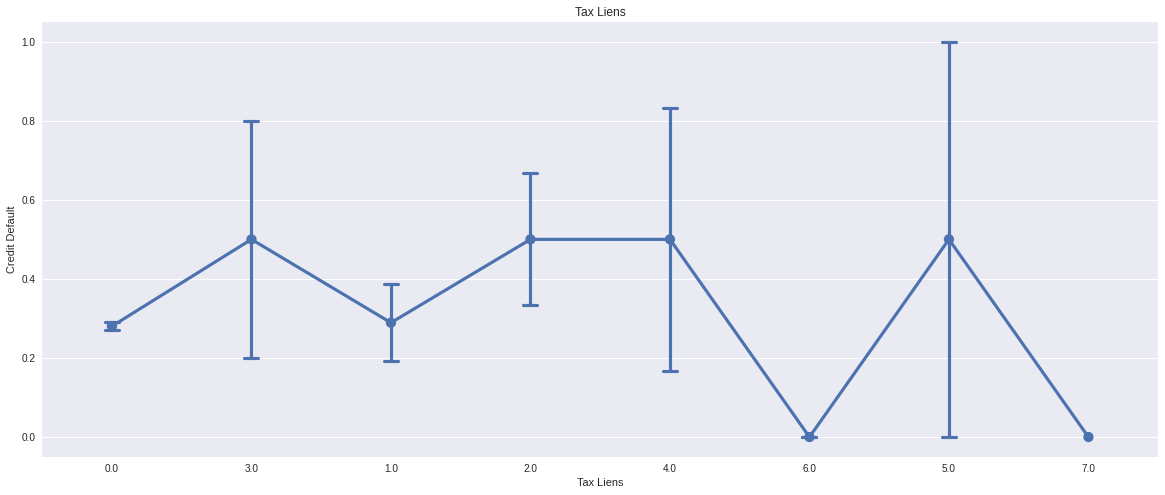

Number of Credit Problems: 
 ['1.0' '0.0' '3.0' '2.0' '6.0' '4.0' '5.0' '7.0'] 



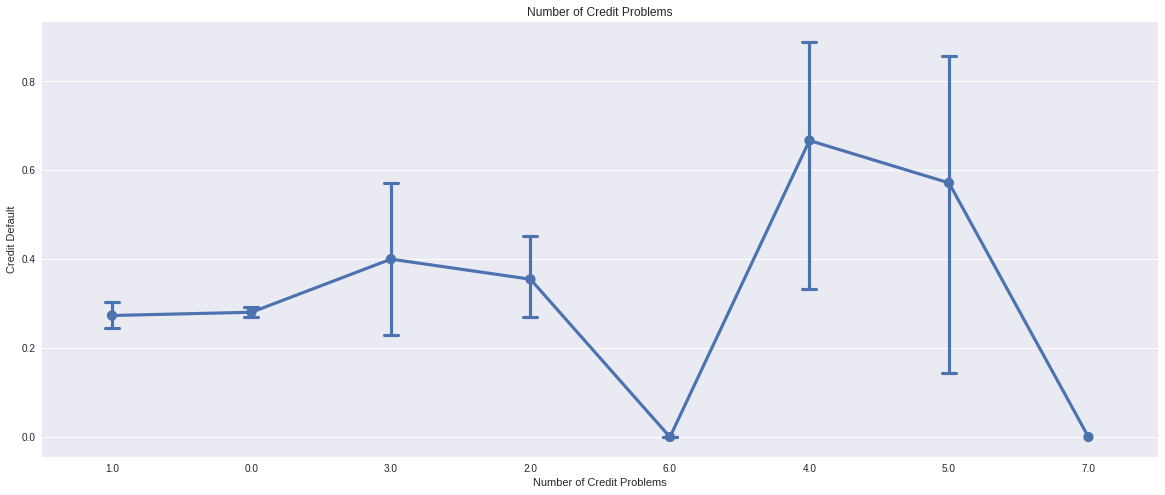

Bankruptcies: 
 ['1.0' '0.0' '3.0' 'nan' '2.0' '4.0'] 



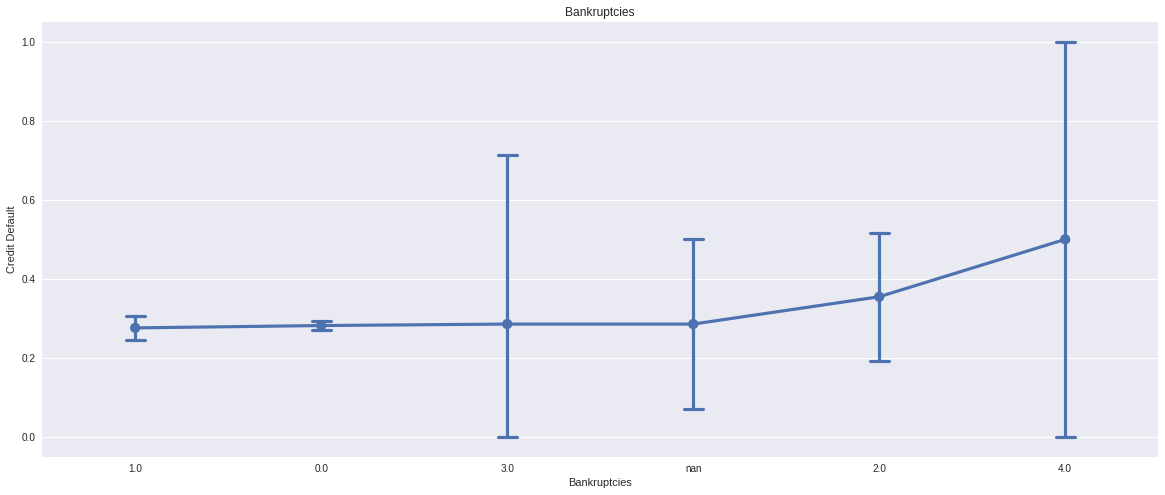

Purpose: 
 ['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation' 'renewable energy'] 



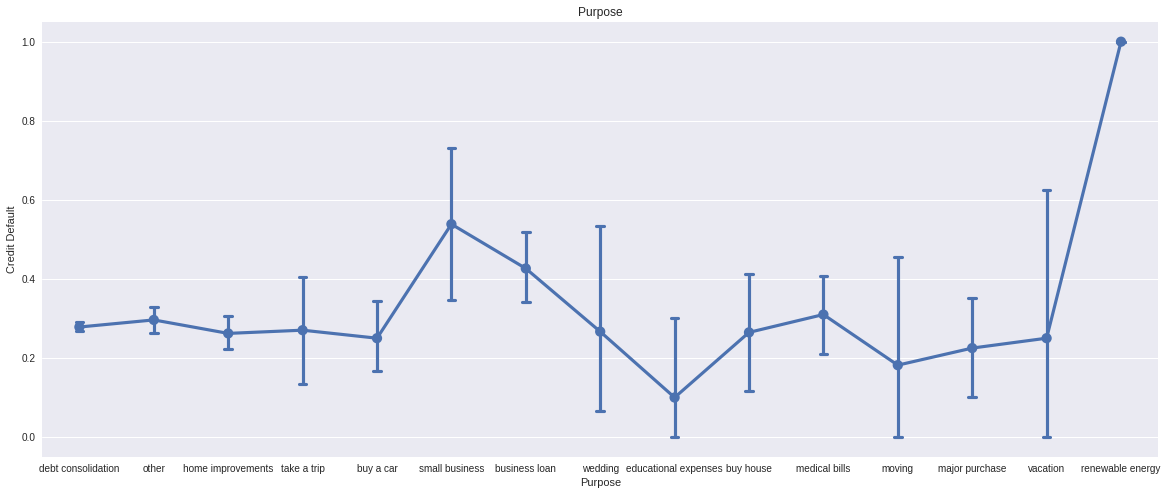

Term: 
 ['Short Term' 'Long Term'] 



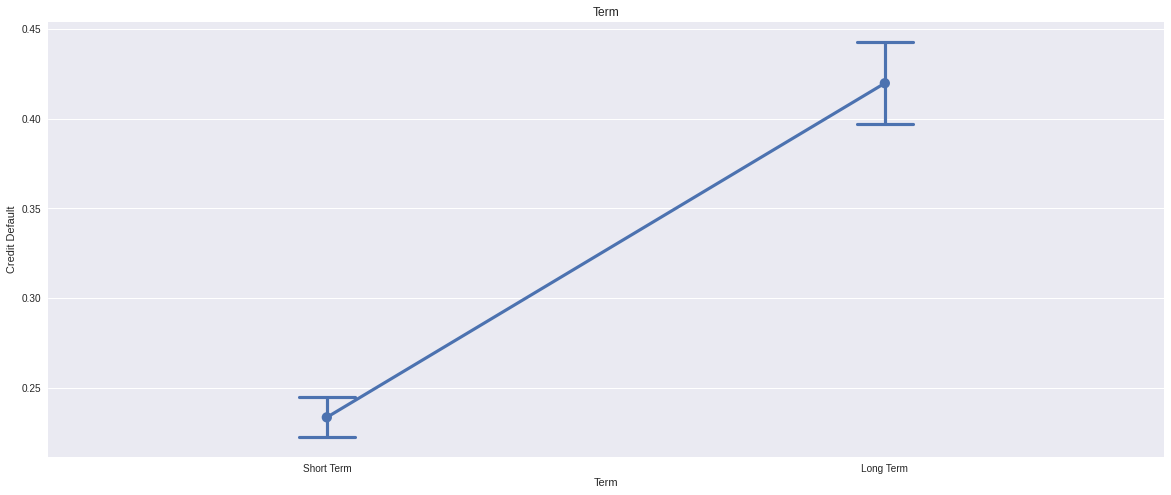

In [70]:
for col in CAT_FEATURE_NAMES:
    x = df_train[col].unique()
    print(f'{col}: \n {x} \n')
    plt.figure(figsize=(20, 8))    
    sns.pointplot(x=col, y=TARGET_NAME, data=df_train, capsize=.1)
    plt.title(col)
    plt.show()

In [71]:
def change_categories(df):
    df.loc[df['Number of Credit Problems'].isin(['6.0', '7.0']), 'Number of Credit Problems'] = '6.0'
    df.loc[df['Number of Credit Problems'].isin(['0.0', '1.0']), 'Number of Credit Problems'] = '1.0'
    df.loc[df['Number of Credit Problems'].isin(['1.0', '2.0', '3.0']), 'Number of Credit Problems'] = '3.0'
    df.loc[df['Tax Liens'].isin(['0.0', '1.0']), 'Tax Liens'] = '1.0'
    df.loc[df['Tax Liens'].isin(['6.0', '7.0']), 'Tax Liens'] = '6.0'
    df.loc[df['Tax Liens'].isin(['2.0', '3.0', '4.0', '5.0']), 'Tax Liens'] = '5.0'
    df.loc[df['Bankruptcies'].isin(['0.0', '1.0']), 'Bankruptcies'] = '1.0'
    df.loc[df['Bankruptcies'].isin(['3.0', 'nan']), 'Bankruptcies'] = '3.0'
    df.loc[df['Bankruptcies'].isin(['1.0', '3.0']), 'Bankruptcies'] = '3.0'
    df.loc[df['Purpose'].isin(['debt consolidation', 'take a trip']), 'Purpose'] = 'take a trip'
    df.loc[df['Purpose'].isin(['buy house', 'home improvements', 'wedding']), 'Purpose'] = 'wedding'
    df.loc[df['Purpose'].isin([ 'buy a car', 'vacation']), 'Purpose'] = 'vacation' 
    df.loc[df['Home Ownership'].isin(['Own Home', 'Rent']), 'Home Ownership'] = 'Own Home'
    df.loc[df['Years in current job'].isin(['1 year', '5 years', '4 years', '7 years', '< 1 year']), 'Years in current job'] = '7 years'
    df.loc[df['Years in current job'].isin(['2 years', '3 years', '10+ years', '8 years']), 'Years in current job'] = '8 years'
    
    return df

df_train = change_categories(df_train)
df_test = change_categories(df_test)    

Home Ownership: 
 ['Own Home' 'Home Mortgage' 'Have Mortgage'] 



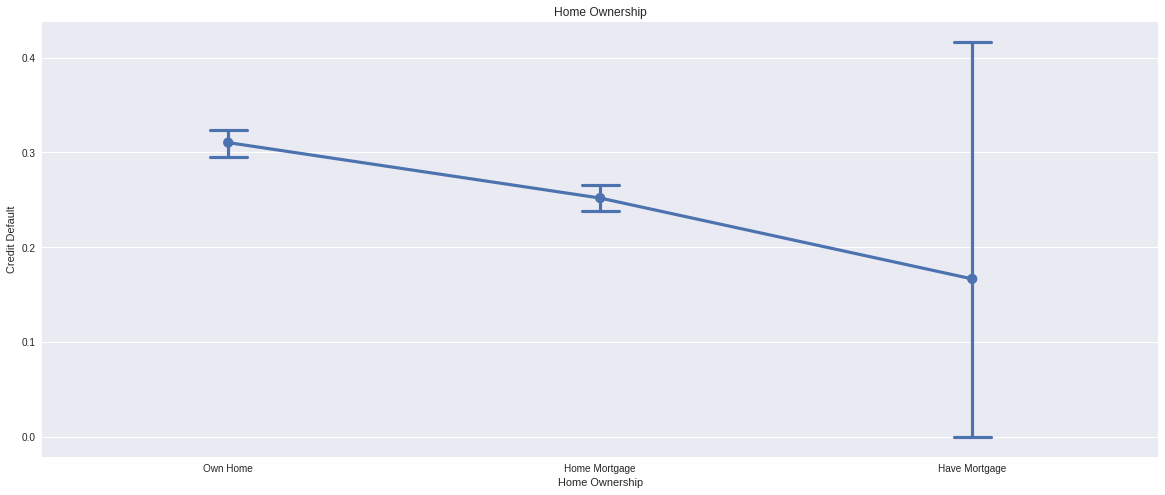

Years in current job: 
 [nan '8 years' '6 years' '7 years' '9 years'] 



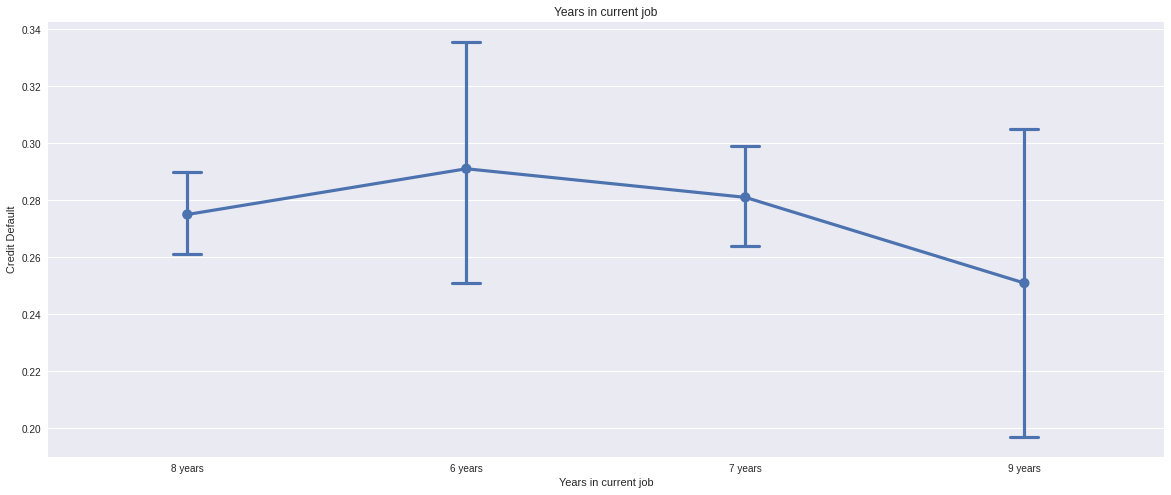

Tax Liens: 
 ['1.0' '5.0' '6.0'] 



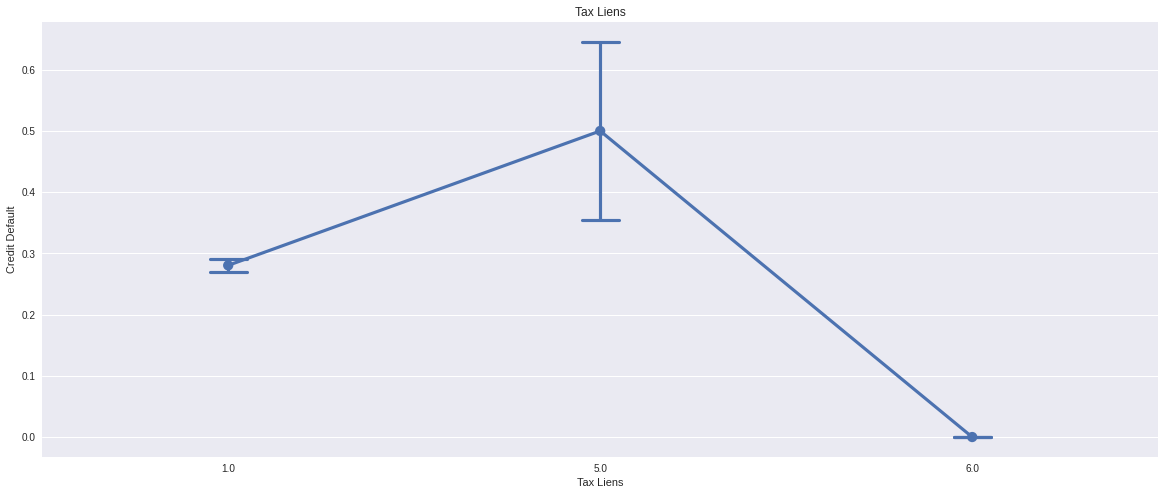

Number of Credit Problems: 
 ['3.0' '6.0' '4.0' '5.0'] 



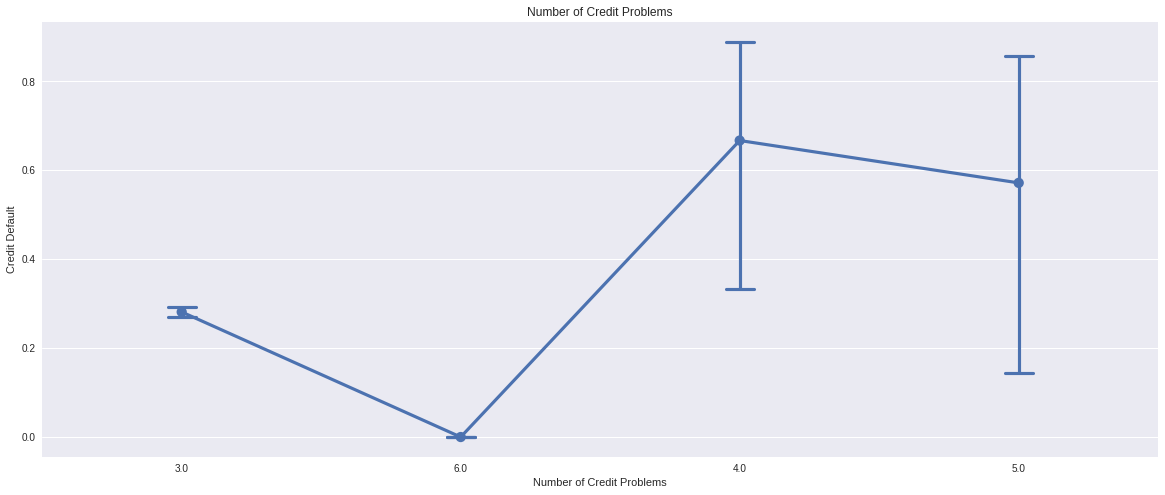

Bankruptcies: 
 ['3.0' '2.0' '4.0'] 



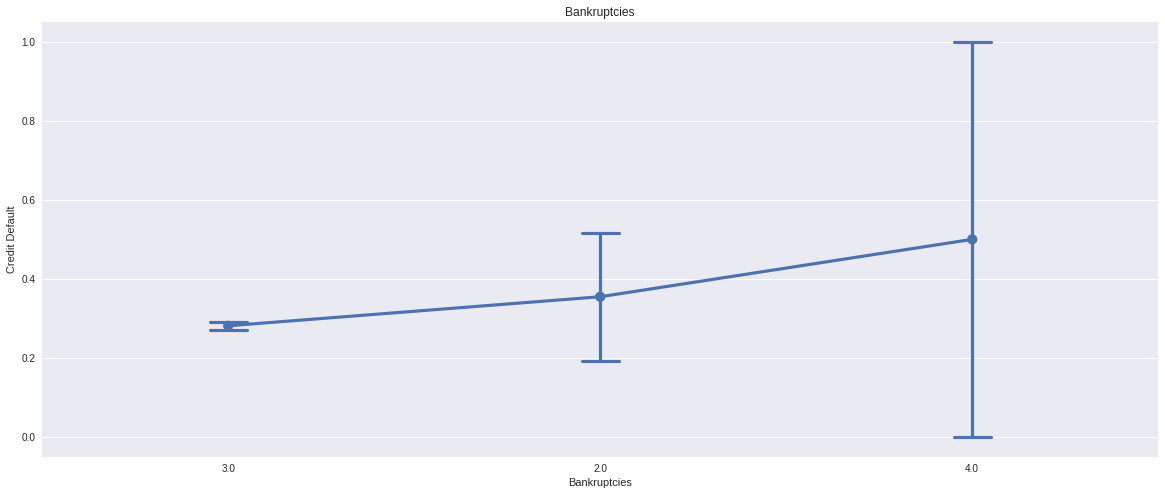

Purpose: 
 ['take a trip' 'other' 'wedding' 'vacation' 'small business'
 'business loan' 'educational expenses' 'medical bills' 'moving'
 'major purchase' 'renewable energy'] 



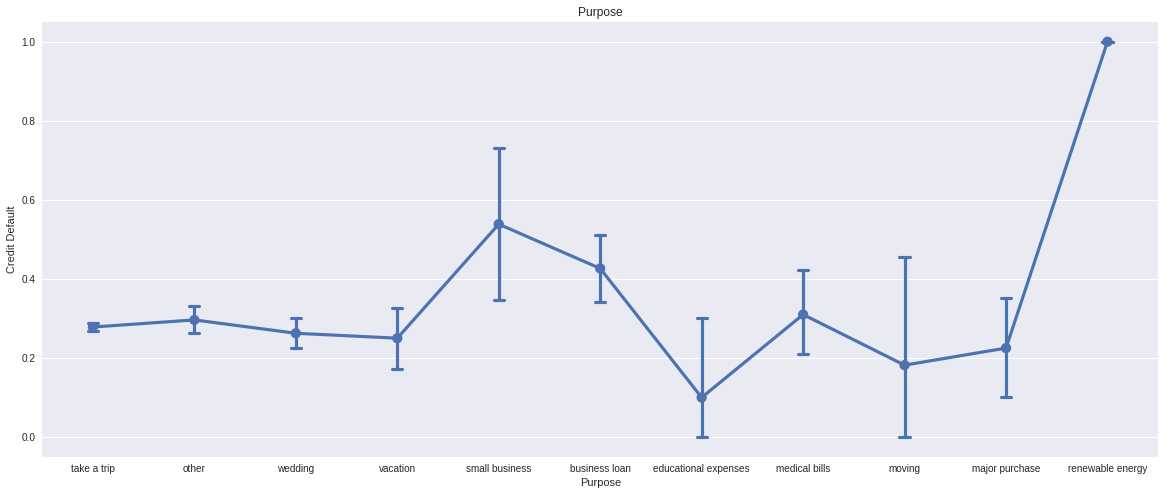

Term: 
 ['Short Term' 'Long Term'] 



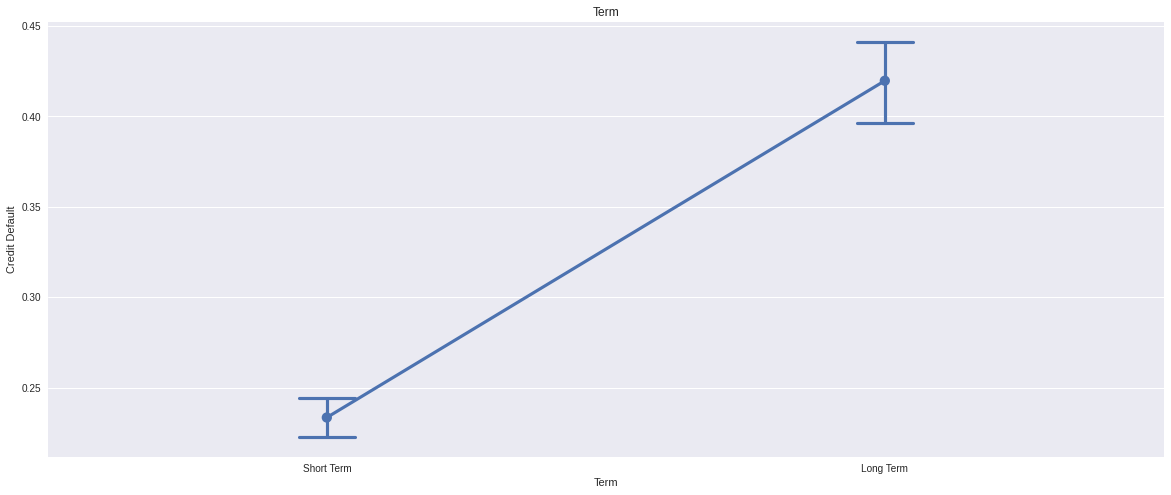

In [72]:
for col in CAT_FEATURE_NAMES:
    x = df_train[col].unique()
    print(f'{col}: \n {x} \n')
    plt.figure(figsize=(20, 8))    
    sns.pointplot(x=col, y=TARGET_NAME, data=df_train, capsize=.1)
    plt.title(col)
    plt.show()

### Заполнение пропусков и обработка выбросов<a class="anchor" id="data_preprocessing"></a> 

**Определение количества пропусков в датасетах**

In [73]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [74]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Обратим внимание на пропуски в параметрах Credit Score (баллы кредитного рейтинга) и Annual Income (годовой доход). Т.е. это люди, у которых нет данных о годовом доходе и отсутсвует кредитный рейтинг. При этом, корреляция между признаками практически отсутствует (-0,04)

In [75]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Own Home         3851
Home Mortgage    3637
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

8 years    3996
7 years    2448
6 years     426
9 years     259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

1.0    7449
5.0      48
6.0       3
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

3.0    7479
4.0       9
5.0       7
6.0       5
Name: Number of Credit Problems, dtype: int64
****************************************************************************************************

Bankruptcies

3.0    7467
2.0      31
4.0       2
Name: Bankruptcies, dtype: int64
*******************************************************************

In [76]:
class DataPreprocessing:
    '''Предварительная обработка данных'''
    
    def __init__(self):
        '''Параметры класса'''
        self.medians = None           
        self.q995 = None 
        
    def fit(self, X):
        self.medians = X.median()        
        self.q995 = X.quantile(0.995) 
        
        # Расчёт медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]
        
    def transform(self, X):
        '''Преобразование данных'''
        
        # Annual Income +
        '''Обработка выбросов'''
        X.loc[X['Annual Income'] > self.q995['Annual Income'], 'Annual Income'] = np.NaN
                
        '''Заполнение пропусков'''
        X.loc[(X['Annual Income'].isna()), 'Annual Income'] = self.medians['Annual Income']
                
        # Credit Score	+
        '''Обработка выбросов (разделили на 10)'''
        X.loc[(X['Credit Score'] > 1000), 'Credit Score'] = X['Credit Score']/10
        X.loc[X['Credit Score'] > self.q995['Credit Score'], 'Credit Score'] = np.NaN
        
        '''Заполнение пропусков'''
        X.loc[(X['Credit Score'].isna()), 'Credit Score'] = self.medians['Credit Score']
        
        # Years in current job +
        '''Заполнение пропусков''' 
        X['Years in current job'].fillna('Not work', inplace = True)
             
        # Bankruptcies +
                
        #'''Заполнение пропусков''' 
        #X.loc[X['Bankruptcies'] == 'nan', 'Bankruptcies'] = '0.0'
        
        # Months since last delinquent   +         
        X['Months since last delinquent outlier'] = 0
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent outlier'] = 1
        
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = 120   
        
        # Maximum Open Credit +
        '''Обработка выбросов'''
        X.loc[X['Maximum Open Credit'] > self.q995['Maximum Open Credit'], 'Maximum Open Credit'] = np.NaN
        
        '''Заполнение пропусков''' 
        X.loc[(X['Maximum Open Credit'].isna()), 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
        # Current Loan Amount +
        '''Обработка выбросов'''
        X.loc[(X['Current Loan Amount'] > 4500000), 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        # Current Credit Balance +
        '''Обработка выбросов'''
        X.loc[X['Current Credit Balance'] > self.q995['Current Credit Balance'], 'Current Credit Balance'] = np.NaN
        
        '''Заполнение пропусков''' 
        X.loc[(X['Current Credit Balance'].isna()), 'Current Credit Balance'] = self.medians['Current Credit Balance']
        
        # Monthly Debt +
        '''Обработка выбросов'''
        X.loc[X['Monthly Debt'] > self.q995['Monthly Debt'], 'Monthly Debt'] = np.NaN
        
        '''Заполнение пропусков''' 
        X.loc[(X['Monthly Debt'].isna()), 'Monthly Debt'] = self.medians['Monthly Debt']
                
        return X

In [77]:
preprocessor = DataPreprocessing()
preprocessor.fit(df_train)  #  fit применяем только к X_train

df_train = preprocessor.transform(df_train)
df_test = preprocessor.transform(df_test)

In [78]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Home Ownership                        7500 non-null   object 
 1   Annual Income                         7500 non-null   float64
 2   Years in current job                  7500 non-null   object 
 3   Tax Liens                             7500 non-null   object 
 4   Number of Open Accounts               7500 non-null   float64
 5   Years of Credit History               7500 non-null   float64
 6   Maximum Open Credit                   7500 non-null   float64
 7   Number of Credit Problems             7500 non-null   object 
 8   Months since last delinquent          7500 non-null   float64
 9   Bankruptcies                          7500 non-null   object 
 10  Purpose                               7500 non-null   object 
 11  Term             

In [79]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Home Ownership                        2500 non-null   object 
 1   Annual Income                         2500 non-null   float64
 2   Years in current job                  2500 non-null   object 
 3   Tax Liens                             2500 non-null   object 
 4   Number of Open Accounts               2500 non-null   float64
 5   Years of Credit History               2500 non-null   float64
 6   Maximum Open Credit                   2500 non-null   float64
 7   Number of Credit Problems             2500 non-null   object 
 8   Months since last delinquent          2500 non-null   float64
 9   Bankruptcies                          2500 non-null   object 
 10  Purpose                               2500 non-null   object 
 11  Term             

In [80]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Own Home         3851
Home Mortgage    3637
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

8 years     3996
7 years     2448
6 years      426
Not work     371
9 years      259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

1.0    7449
5.0      48
6.0       3
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

3.0    7479
4.0       9
5.0       7
6.0       5
Name: Number of Credit Problems, dtype: int64
****************************************************************************************************

Bankruptcies

3.0    7467
2.0      31
4.0       2
Name: Bankruptcies, dtype: int64
**********************************************

### Конвертация категориальных признаков в цифровой вид<a class="anchor" id="cat_feature_convert"></a> 

**Home Ownership**

In [81]:
df_train['Home Ownership'].value_counts()

Own Home         3851
Home Mortgage    3637
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [82]:
df_cat_HO = df_train.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Credit Default']].rename(columns={
    'Credit Default': 'target_encode_Home_Ownership'
})
df_cat_HO = pd.DataFrame(df_cat_HO)

df_cat_HO

,Home Ownership,target_encode_Home_Ownership
0,Have Mortgage,0.166667
1,Home Mortgage,0.251856
2,Own Home,0.310309


In [83]:
df_train = df_train.merge(df_cat_HO, on='Home Ownership', how='left')
df_test = df_test.merge(df_cat_HO, on='Home Ownership', how='left')

**Years in current job**

In [84]:
df_train['Years in current job'].value_counts()

8 years     3996
7 years     2448
6 years      426
Not work     371
9 years      259
Name: Years in current job, dtype: int64

In [85]:
df_cat_year = df_train.groupby('Years in current job', as_index=False).mean()[['Years in current job', 'Credit Default']].rename(columns={
    'Credit Default': 'target_encode_Years_in_current_job'
})
df_cat_year = pd.DataFrame(df_cat_year)

df_cat_year

,Years in current job,target_encode_Years_in_current_job
0,6 years,0.291080
1,7 years,0.281046
2,8 years,0.275025
3,9 years,0.250965
4,Not work,0.369272


In [86]:
df_train = df_train.merge(df_cat_year, on='Years in current job', how='left')
df_test = df_test.merge(df_cat_year, on='Years in current job', how='left')

**Tax Liens**

In [87]:
df_train['Tax Liens'].value_counts()

1.0    7449
5.0      48
6.0       3
Name: Tax Liens, dtype: int64

In [88]:
df_cat_tl = df_train.groupby('Tax Liens', as_index=False).mean()[['Tax Liens', 'Credit Default']].rename(columns={
    'Credit Default': 'target_encode_Tax_Liens'
})
df_cat_tl = pd.DataFrame(df_cat_tl)

df_cat_tl

,Tax Liens,target_encode_Tax_Liens
0,1.0,0.28044
1,5.0,0.50000
2,6.0,0.00000


In [89]:
df_train = df_train.merge(df_cat_tl, on='Tax Liens', how='left')
df_test = df_test.merge(df_cat_tl, on='Tax Liens', how='left')

**Number of Credit Problems**

In [90]:
df_train['Number of Credit Problems'].value_counts()

3.0    7479
4.0       9
5.0       7
6.0       5
Name: Number of Credit Problems, dtype: int64

In [91]:
df_cat_cp = df_train.groupby('Number of Credit Problems', as_index=False).mean()[['Number of Credit Problems', 'Credit Default']].rename(columns={
    'Credit Default': 'target_encode_Number_of_Credit_Problems'
})
df_cat_cp = pd.DataFrame(df_cat_cp)

df_cat_cp

,Number of Credit Problems,target_encode_Number_of_Credit_Problems
0,3.0,0.281187
1,4.0,0.666667
2,5.0,0.571429
3,6.0,0.000000


In [92]:
df_train = df_train.merge(df_cat_cp, on='Number of Credit Problems', how='left')
df_test = df_test.merge(df_cat_cp, on='Number of Credit Problems', how='left')

**Bankruptcies**

In [93]:
df_train['Bankruptcies'].value_counts()

3.0    7467
2.0      31
4.0       2
Name: Bankruptcies, dtype: int64

In [94]:
df_cat_ban = df_train.groupby('Bankruptcies', as_index=False).mean()[['Bankruptcies', 'Credit Default']].rename(columns={
    'Credit Default': 'target_encode_Bankruptcies'
})
df_cat_ban = pd.DataFrame(df_cat_ban)

df_cat_ban

,Bankruptcies,target_encode_Bankruptcies
0,2.0,0.354839
1,3.0,0.281371
2,4.0,0.500000


In [95]:
df_train = df_train.merge(df_cat_ban, on='Bankruptcies', how='left')
df_test = df_test.merge(df_cat_ban, on='Bankruptcies', how='left')

**Purpose**

In [96]:
df_train['Purpose'].value_counts()

take a trip             5981
other                    665
wedding                  461
business loan            129
vacation                 104
medical bills             71
major purchase            40
small business            26
moving                    11
educational expenses      10
renewable energy           2
Name: Purpose, dtype: int64

In [97]:
df_cat_pur = df_train.groupby('Purpose', as_index=False).mean()[['Purpose', 'Credit Default']].rename(columns={
    'Credit Default': 'target_encode_Purpose'
})
df_cat_pur = pd.DataFrame(df_cat_pur)

df_cat_pur

,Purpose,target_encode_Purpose
0,business loan,0.426357
1,educational expenses,0.100000
2,major purchase,0.225000
3,medical bills,0.309859
4,moving,0.181818
5,other,0.296241
6,renewable energy,1.000000
7,small business,0.538462
8,take a trip,0.278214
9,vacation,0.250000


In [98]:
df_train = df_train.merge(df_cat_pur, on='Purpose', how='left')
df_test = df_test.merge(df_cat_pur, on='Purpose', how='left')

**Term**

In [99]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [100]:
df_cat_t = df_train.groupby('Term', as_index=False).mean()[['Term', 'Credit Default']].rename(columns={
    'Credit Default': 'target_encode_Term'
})
df_cat_t = pd.DataFrame(df_cat_t)

df_cat_t

,Term,target_encode_Term
0,Long Term,0.419753
1,Short Term,0.233441


In [101]:
df_train = df_train.merge(df_cat_t, on='Term', how='left')
df_test = df_test.merge(df_cat_t, on='Term', how='left')

### Проверка распределения вещественных признаков на трейне и тесте<a class="anchor" id="num_feature_distribution_checking"></a> 

Annual Income
MannwhitneyuResult(statistic=9357740.5, pvalue=0.8896728441913959)


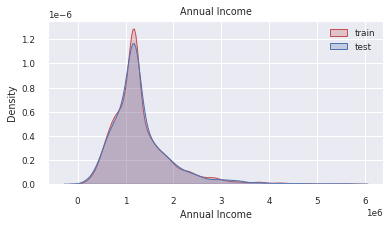

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.4428527435772891)


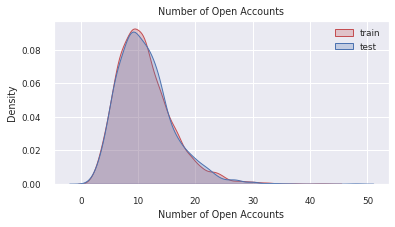

Years of Credit History
MannwhitneyuResult(statistic=9410342.0, pvalue=0.7773891904970164)


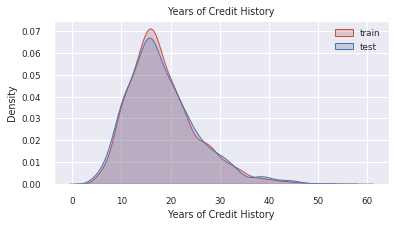

Maximum Open Credit
MannwhitneyuResult(statistic=9331560.0, pvalue=0.7282166705009421)


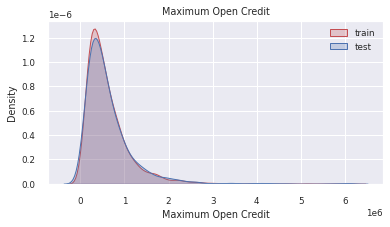

Months since last delinquent
MannwhitneyuResult(statistic=9417199.5, pvalue=0.7124806386470582)


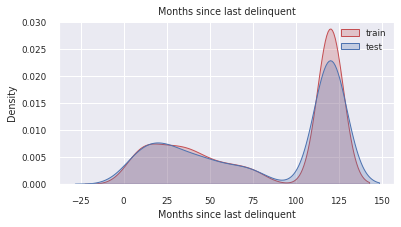

Current Loan Amount
MannwhitneyuResult(statistic=9221649.5, pvalue=0.21955409249324165)


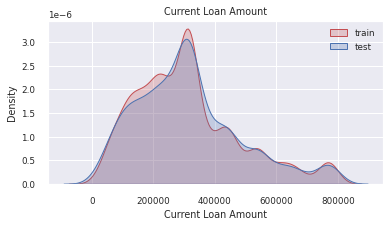

Current Credit Balance
MannwhitneyuResult(statistic=9443836.0, pvalue=0.5818691030816772)


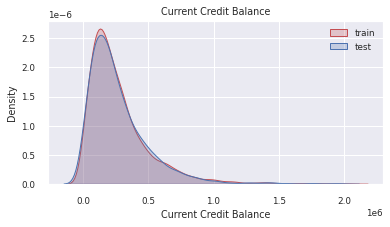

Monthly Debt
MannwhitneyuResult(statistic=9287786.0, pvalue=0.4853816127122915)


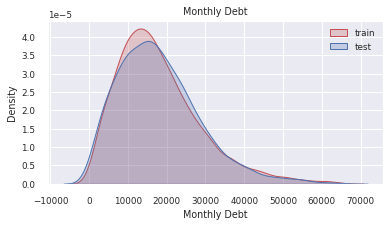

Credit Score
MannwhitneyuResult(statistic=9534525.5, pvalue=0.19943501407784625)


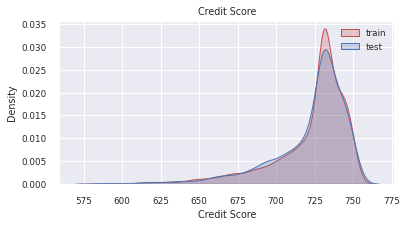

In [102]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df_train[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='b')
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

На основании графиков можно сделать вывод, что распределение количественных признаков на трайне и тесте схоже.

### Проверка распределение категориальных признаков на трейне и тесте<a class="anchor" id="cat_feature_distribution_checking"></a> 

Из-за отсутсвия в test целевой переменной, сравнение будем производить с привязкой к параметрам Credit Score и Current Loan Amount, как имеющих наибольшую корреляцию с целевой переменной.

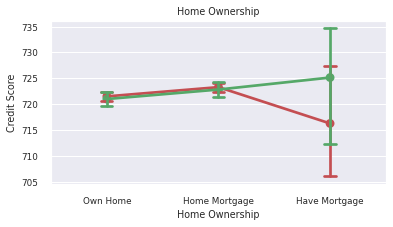

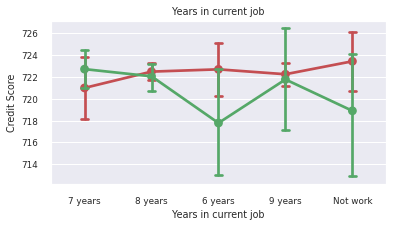

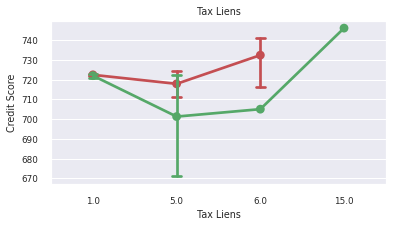

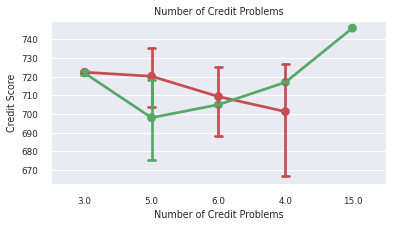

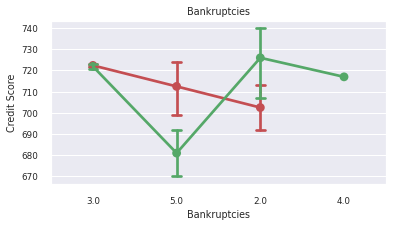

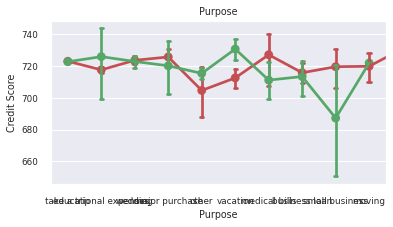

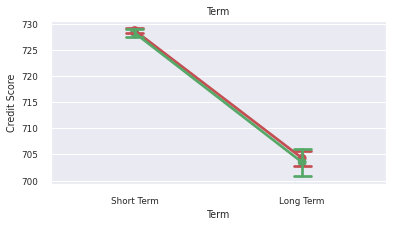

In [103]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

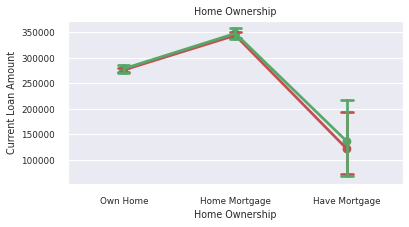

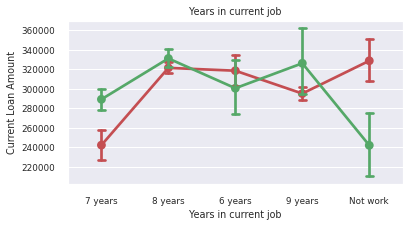

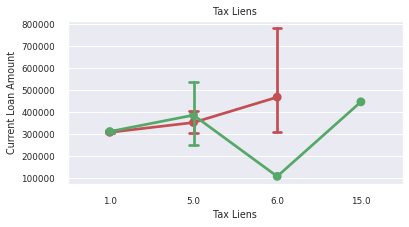

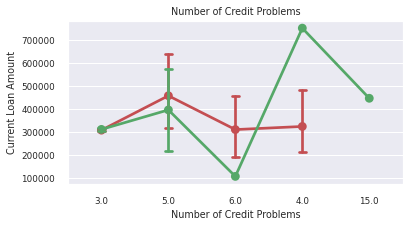

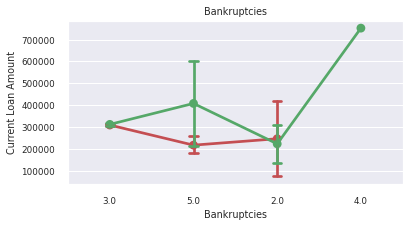

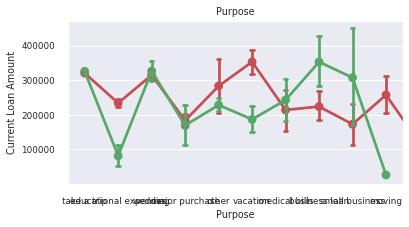

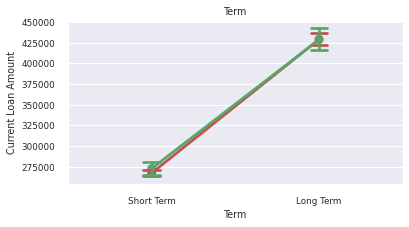

In [104]:
num_feature = 'Current Loan Amount'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

По итогам сравнения, появилась идея не включать признаки Tax Liens (налоговые обременения) и Purpose (цель кредита) в модель, т.к. их распределения в тесте и трайне имеют существенные расхождения

## Построение моделей (XGBoost)<a class="anchor" id="xgboost_modeling"></a> 

По итогам применения разных моделей, остановился на XGBoost. Остальные были удалены, для экономии времени и места

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [105]:
CAT_FEATURE_NAMES = [
                     'Home Ownership', 
                     'Years in current job', 
                     'Tax Liens',
                     'Number of Credit Problems', 
                     'Bankruptcies', 
                     'Purpose',
                     'Term'
]

NUM_FEATURE_NAMES = [
                     'Annual Income', 
                     'Number of Open Accounts', 
                     'Years of Credit History', 
                     'Maximum Open Credit', 
                     'Months since last delinquent',
                     'Months since last delinquent outlier',
                     'Current Loan Amount', 
                     'Current Credit Balance', 
                     'Monthly Debt', 
                     'Credit Score'
]

NEW_FEATURE_NAMES = [
                     'target_encode_Home_Ownership',
                     'target_encode_Years_in_current_job',
                     'target_encode_Tax_Liens',
                     'target_encode_Number_of_Credit_Problems',
                     'target_encode_Bankruptcies',
                     'target_encode_Term',
                     'target_encode_Purpose'
]

In [106]:
FEATURE_NAMES_XGB = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

In [107]:
X = df_train[FEATURE_NAMES_XGB]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      shuffle=True,
                                                      test_size=0.333,
                                                      random_state=42,
                                                      stratify=y
                                                     )


In [108]:
#Определение значения дисбаланса целевой переменной

disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5500354861603975

### Масштабирование данных<a class="anchor" id="scaler"></a>

In [109]:
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train[NUM_FEATURE_NAMES] = scaler.fit_transform(X_train_norm[NUM_FEATURE_NAMES])
X_test[NUM_FEATURE_NAMES] = scaler.transform(X_test_norm[NUM_FEATURE_NAMES])

**Сохранение модели для масштабирования данных**

In [110]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

**Сохранение обучающего и тестового датасетов**

In [111]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [112]:
df_train.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

In [113]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3593
1    2818
Name: Credit Default, dtype: int64

In [114]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

### Обучение модели<a class="anchor" id="model_training"></a> 

In [115]:
model_xgb = xgb.XGBClassifier(
                             num_parallel_tree=10, 
                             colsample_bytree=0.3, 
                             learning_rate=0.03,
                             max_depth=3,
                             n_estimators=324,
                             reg_lambda=13,
                             scale_pos_weight = disbalance,
                             n_jobs=-1,
                             subsample=0.6, 
                             seed=42,
                             random_state=42,  
                             objective='binary:logistic'
)
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[06:22:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.95      0.30      0.46      3593
           1       0.52      0.98      0.68      2818

    accuracy                           0.60      6411
   macro avg       0.74      0.64      0.57      6411
weighted avg       0.76      0.60      0.56      6411

TEST

              precision    recall  f1-score   support

           0       0.94      0.29      0.44      1794
           1       0.34      0.95      0.50       704

    accuracy                           0.47      2498
   macro avg       0.64      0.62      0.47      2498
weighted avg       0.77      0.47      0.46      2498

CONFUSION MATRIX

col_0             0     1
Credit Default           
0          

### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [116]:
frozen_params = {
               'num_parallel_tree': 5,
               'colsample_bytree': 0.3, 
               'learning_rate': 0.03,
               'max_depth': 5,
               'n_estimators': 224, 
               'reg_lambda': 13,
               'scale_pos_weight': disbalance,
               'n_jobs': -1,
               'subsample': 0.6, 
               'seed': 42,
               'random_state': 42,
               'use_label_encoder': False,
               'objective':'binary:logistic'
                }

### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

/home/gans/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/gans/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/gans/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWa

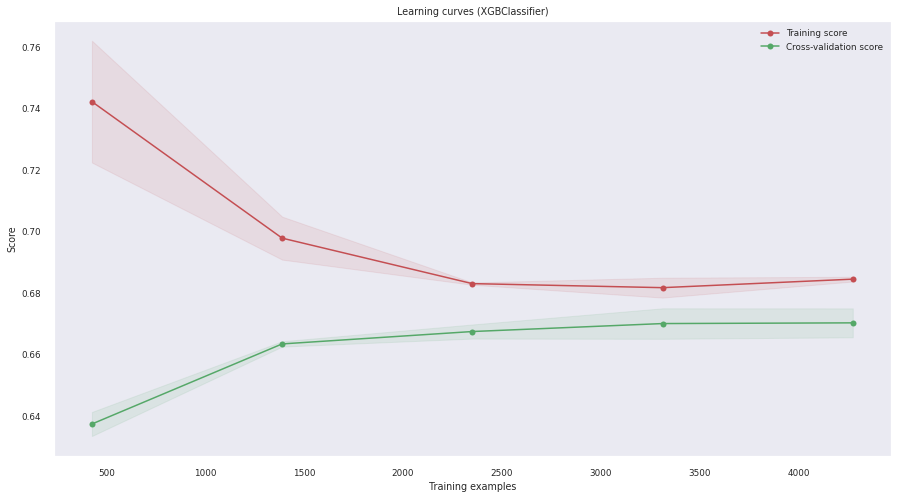

In [117]:
show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

По графику видно, что сближенение кривых происходит на всех данных, поэтому объем выборки оставляем

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

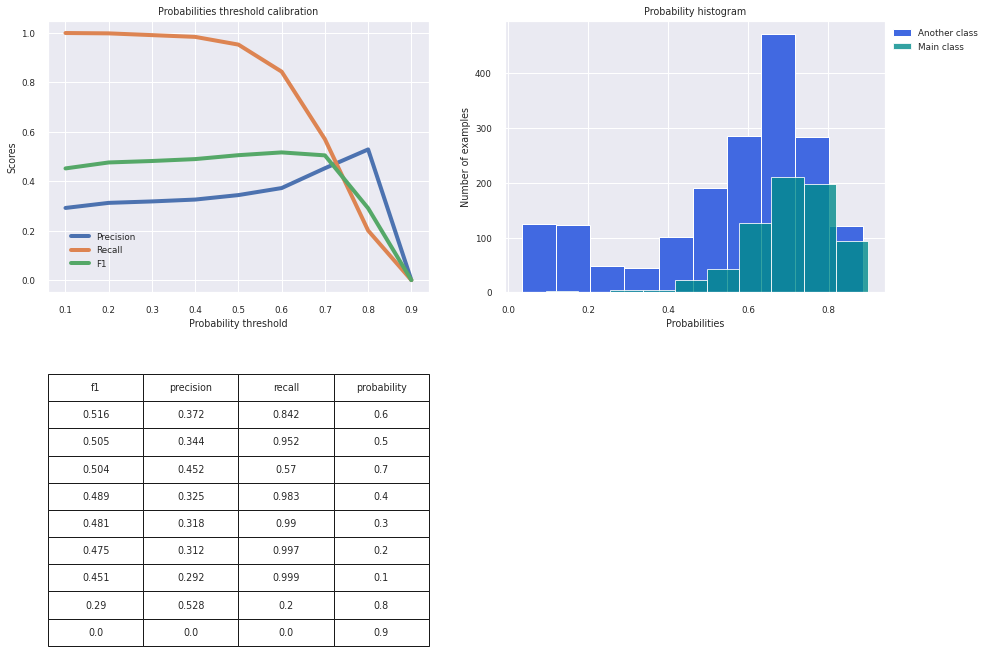

In [118]:
y_test_pred_probs = model_xgb.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков <a class="anchor" id="feature_importances"></a>

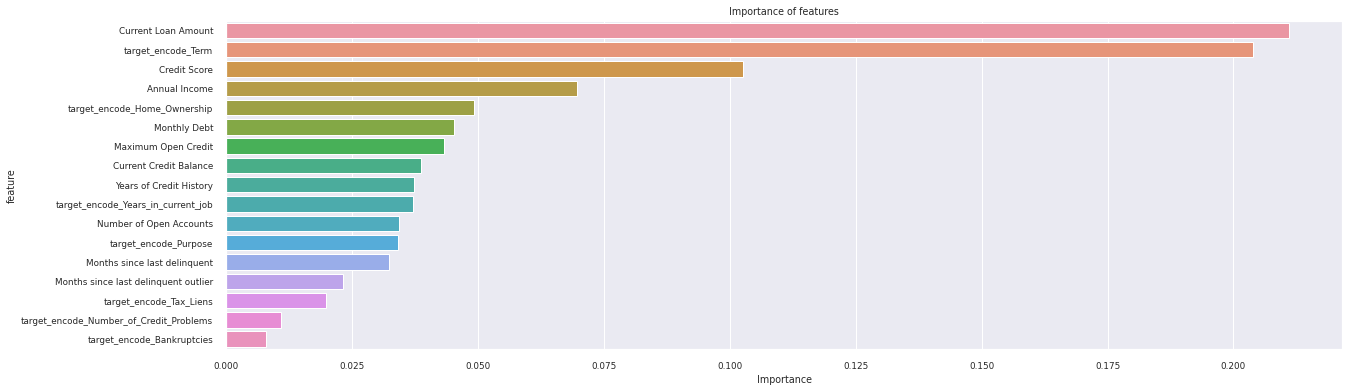

In [119]:
important_features_top = show_feature_importances(X_train_balanced.columns,
                                                  model_xgb.feature_importances_, get_top=17) # было 16 

In [120]:
important_features_top

['Current Loan Amount',
 'target_encode_Term',
 'Credit Score',
 'Annual Income',
 'target_encode_Home_Ownership',
 'Monthly Debt',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Years of Credit History',
 'target_encode_Years_in_current_job',
 'Number of Open Accounts',
 'target_encode_Purpose',
 'Months since last delinquent',
 'Months since last delinquent outlier',
 'target_encode_Tax_Liens',
 'target_encode_Number_of_Credit_Problems',
 'target_encode_Bankruptcies']

###  Построение финальной модели <a class="anchor" id="final_model"></a>

In [121]:
final_model = xgb.XGBClassifier(**frozen_params)
final_model.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(final_model,
               X_train_balanced[important_features_top],
               X_test[important_features_top],
               y_train_balanced,
               y_test)

[06:23:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.98      0.34      0.50      3593
           1       0.54      0.99      0.70      2818

    accuracy                           0.62      6411
   macro avg       0.76      0.66      0.60      6411
weighted avg       0.78      0.62      0.59      6411

TEST

              precision    recall  f1-score   support

           0       0.92      0.31      0.46      1794
           1       0.35      0.93      0.50       704

    accuracy                           0.48      2498
   macro avg       0.63      0.62      0.48      2498
weighted avg       0.76      0.48      0.47      2498

CONFUSION MATRIX

col_0             0     1
Credit Default           
0          

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.34      0.50      3593
           1       0.54      0.99      0.70      2818

    accuracy                           0.62      6411
   macro avg       0.76      0.66      0.60      6411
weighted avg       0.78      0.62      0.59      6411

TEST

              precision    recall  f1-score   support

           0       0.93      0.31      0.46      1794
           1       0.35      0.94      0.51       704

    accuracy                           0.48      2498
   macro avg       0.64      0.62      0.48      2498
weighted avg       0.76      0.48      0.47      2498

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               548  1246
1                44   660

### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [122]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

## Прогнозирование на тестовом датасете<a class="anchor" id="forecasting_test_dataset"></a>

In [123]:
X = X[FEATURE_NAMES_XGB]
df_test = df_test[FEATURE_NAMES_XGB]

# Определение гиперпараметров финальной модели
final_model = xgb.XGBClassifier(**frozen_params)

# Обучение финальной модели
final_model.fit(X, y)

# Прогнозирование на тестовом датасете
y_test_preds_cat = final_model.predict(df_test)

[06:23:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


**Сохранение результатов**

In [124]:
submit = pd.read_csv(SUBMISSION_PATH)
submit['Credit Default'] = y_test_preds_cat
submit.to_csv('../5_submits/gusev_submit.csv', index=False)